# Capstone NN #

**Summary**
1. Я исправил формат данных из работы #7 и получил точность 0.81 (до исправления была 0.92) на логистической регрессии и 0.82 на нейронке.
2. Нейронка не смогла заоверфититься на тренировочные данные. Нужно поработать над фичами.

In [1]:
import json
import random
from sklearn.model_selection import cross_val_score

Загружаем данные:

In [2]:
PATH_TO_SCIQ_DATASET = 'data/SciQ dataset/'
TEST_FILENAME = 'test.json'
TRAIN_FILENAME = 'train.json'
VALIDATION_FILENAME = 'valid.json'

with open(PATH_TO_SCIQ_DATASET+TEST_FILENAME,'r') as json_file:
    test_data =  json.load(json_file)

with open(PATH_TO_SCIQ_DATASET+TRAIN_FILENAME,'r') as json_file:
    train_data =  json.load(json_file)

with open(PATH_TO_SCIQ_DATASET+VALIDATION_FILENAME,'r') as json_file:
    validation_data =  json.load(json_file)

    
print('test_data:',len(test_data))
print('train_data:',len(train_data))
print('validation_data:',len(validation_data))

test_data: 1000
train_data: 11679
validation_data: 1000


```json5
{
    "question": "Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?",
    "distractor3": "residues",
    "distractor1": "antioxidants",
    "distractor2": "Oxygen",
    "correct_answer": "oxidants",
    "support": "Oxidants and Reductants Compounds that are capable of accepting electrons, such as O 2 or F2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. In the process of accepting electrons, an oxidant is reduced. Compounds that are capable of donating electrons, such as sodium metal or cyclohexane (C6H12), are calledreductants (or reducing agents) because they can cause the reduction of another compound. In the process of donating electrons, a reductant is oxidized. These relationships are summarized in Equation 3.30: Equation 3.30 Saylor URL: http://www. saylor. org/books."
}
```
Я преобразую данные в два вектора: в первом будут варианты ответов (distractor1, distractor2, distractor3, correct_answer) и фичи, которые я извлеку из support. Например, встречается ли каждый из этих вариантов ответа в тексте?
Вторым вектором будет вектор метор, где `True` означает правильный ответ, а `False` - дистрактор: [False False False True]
Также перед добавлением вариантов ответа в общий вектор, я буду их перемешивать.

In [33]:
!pip install flatdict

  Created wheel for flatdict: filename=flatdict-4.0.1-py3-none-any.whl size=6932 sha256=e40826da48076c2f3d9272200b321ddc259101375793361ebd0c5c5301f4042c
  Stored in directory: /Users/dmytromindra/Library/Caches/pip/wheels/93/67/8f/9d074db7f341c7a487f1dfb9758390cf8108f87ab78fda89ef
Successfully built flatdict


In [24]:

def get_answer_features(answer, support):
    features = {}
    if support.lower().find(answer.lower())>-1:
        features['present_in_support'] = True
    else:
        features['present_in_support'] = False
    return features

def get_question_features(question_data):
    
    question = question_data["question"]
    distractors = [question_data["distractor1"], question_data["distractor2"],question_data["distractor3"]]
    correct_answer = question_data["correct_answer"]
    support = question_data["support"]
    answers = distractors + [correct_answer]
    random.shuffle(answers)
    
    features = {}
    
    correct_answer_id = 0
    answer_id = 0
    for answer in answers:
        
        features['answer{}'.format(answer_id)] = get_answer_features(answer, support)

        if answer == correct_answer:
            correct_answer_id = answer_id 
        
        answer_id +=1
        
    return features,correct_answer_id

get_question_features(test_data[105])

({'answer0': {'present_in_support': False},
  'answer1': {'present_in_support': True},
  'answer2': {'present_in_support': False},
  'answer3': {'present_in_support': True}},
 1)

# LogisticRegression

In [56]:
train_data_features = []
train_data_labels = []
test_data_features = []
test_data_labels = []

import flatdict

for question in train_data:
    features,correct_answer_id = get_question_features(question)
    train_data_features.append(dict(flatdict.FlatDict(features)))
    train_data_labels.append(correct_answer_id)

for question in test_data:
    features,correct_answer_id = get_question_features(question)
    test_data_features.append(dict(flatdict.FlatDict(features)))
    test_data_labels.append(correct_answer_id)

import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print (train_data_features[:1])
print ()

vectorizer = DictVectorizer(sparse=False)

train_features_vectorized = vectorizer.fit_transform(train_data_features)
test_features_vectorized = vectorizer.transform(test_data_features)

lrc = LogisticRegression(random_state=42, solver="sag", multi_class="multinomial",
                             max_iter=50, verbose=0)

lrc.fit(train_features_vectorized, train_data_labels)

scores = cross_val_score(lrc, train_features_vectorized, train_data_labels, cv=5)

print ('Cross validation:')
print (scores)

print ('classification_report:')
predicted_labels = lrc.predict(test_features_vectorized)
print(classification_report(test_data_labels, predicted_labels))

[{'answer0:present_in_support': False, 'answer1:present_in_support': False, 'answer2:present_in_support': True, 'answer3:present_in_support': False}]

Cross validation:
[0.81078767 0.81035959 0.80436644 0.80008562 0.8124197 ]
classification_report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       265
           1       0.93      0.75      0.83       232
           2       0.97      0.74      0.84       239
           3       0.64      0.95      0.77       264

    accuracy                           0.81      1000
   macro avg       0.85      0.81      0.82      1000
weighted avg       0.85      0.81      0.82      1000



# NN

In [77]:
!pip install matplotlib

In [78]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [73]:
X_train = np.array(train_features_vectorized)
y_train = np.array(train_data_labels)
X_test = np.array(test_features_vectorized)
y_test = np.array(test_data_labels)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 404       
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 404       
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________
Train on 11679 samples, validate o

11679/11679 [==============================] - 1s 93us/step - loss: 0.3516 - accuracy: 0.8103 - val_loss: 0.3651 - val_accuracy: 0.8000
Epoch 48/100
11679/11679 [==============================] - 1s 92us/step - loss: 0.3512 - accuracy: 0.8113 - val_loss: 0.3648 - val_accuracy: 0.8110
Epoch 49/100
11679/11679 [==============================] - 1s 94us/step - loss: 0.3517 - accuracy: 0.8109 - val_loss: 0.3690 - val_accuracy: 0.8010
Epoch 50/100
11679/11679 [==============================] - 1s 94us/step - loss: 0.3518 - accuracy: 0.8099 - val_loss: 0.3648 - val_accuracy: 0.8140
Epoch 51/100
11679/11679 [==============================] - 1s 95us/step - loss: 0.3514 - accuracy: 0.8090 - val_loss: 0.3698 - val_accuracy: 0.8010
Epoch 52/100
11679/11679 [==============================] - 1s 95us/step - loss: 0.3515 - accuracy: 0.8123 - val_loss: 0.3656 - val_accuracy: 0.8030
Epoch 53/100
11679/11679 [==============================] - 1s 95us/step - loss: 0.3514 - accuracy: 0.8123 - val_loss: 

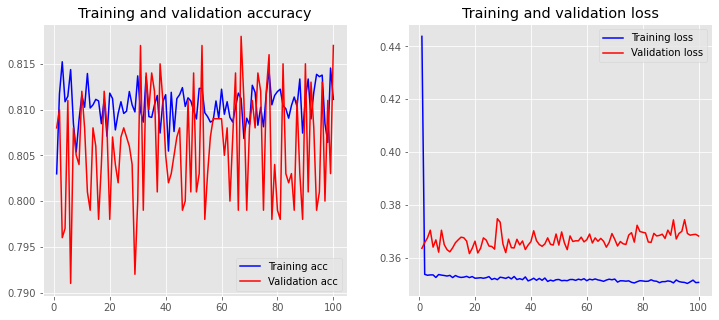

In [80]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten

n_categories = 4

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(n_categories, activation='softmax')) 
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Модель не смогла заоверфититься на тренировочные данные.